# Download do dataset

In [ ]:
import zipfile
import os
from google.colab import files

# Faça o upload do arquivo kaggle.json
uploaded = files.upload()

# Configure as variáveis de ambiente para a API do Kaggle
os.environ['KAGGLE_CONFIG_DIR'] = '/content'
!chmod 600 /content/kaggle.json

# Baixe o conjunto de dados
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000 --force

# Descompacte o arquivo baixado
with zipfile.ZipFile('/content/skin-cancer-mnist-ham10000.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/skin-cancer-mnist-ham10000/')

Saving kaggle.json to kaggle.json
100% 5.19G/5.20G [00:43<00:00, 163MB/s]
100% 5.20G/5.20G [00:43<00:00, 129MB/s]


---
# Download das bibliotecas

In [ ]:
# Instalação de pacotes necessários
!pip install optuna mlflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.6/147.6 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.2 MB/s eta 0:00:00


In [ ]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)

import itertools
import keras
from keras import regularizers
from tensorflow.keras.utils import to_categorical
from keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, save_img
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Input, Lambda
from tensorflow.keras.optimizers import Adam
import optuna
import mlflow
from tensorflow.keras.applications import EfficientNetB0, ResNet50, VGG16, InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_inception_v3
import tensorflow as tf
import pickle
from sklearn.metrics import classification_report, confusion_matrix


---
# Importação do dataset

In [ ]:
base_skin_dir = os.path.join('/content/skin-cancer-mnist-ham10000')

In [ ]:
# Merge images from both folders into one dictionary
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

lesion_danger = {
    'nv': 0, # 0 for benign
    'mel': 1, # 1 for malignant
    'bkl': 0, # 0 for benign
    'bcc': 1, # 1 for malignant
    'akiec': 1, # 1 for malignant
    'vasc': 0,
    'df': 0
}


In [ ]:
# Read in the csv of metadata

tile_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))
tile_df.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

In [ ]:
# Create some new columns (path to image, human-readable name) and review them

tile_df['path'] = tile_df['image_id'].map(imageid_path_dict.get)
tile_df['cell_type'] = tile_df['dx'].map(lesion_type_dict.get)
tile_df['malignant'] = tile_df['dx'].map(lesion_danger.get)
tile_df['cell_type_idx'] = pd.Categorical(tile_df['cell_type']).codes # give each cell type a category id
tile_df.sample(5)

lesion_id      image_id     dx    dx_type   age     sex  \
9725  HAM_0004376  ISIC_0024843  akiec      histo  70.0  female   
6059  HAM_0003024  ISIC_0024768     nv  follow_up  35.0  female   
4540  HAM_0001659  ISIC_0026564     nv  follow_up  35.0    male   
3817  HAM_0004625  ISIC_0029346     nv  follow_up  40.0    male   
7914  HAM_0000443  ISIC_0034271     nv      histo  35.0  female   

         localization                                               path  \
9725             face  /content/skin-cancer-mnist-ham10000/ham10000_i...   
6059            trunk  /content/skin-cancer-mnist-ham10000/ham10000_i...   
4540  lower extremity  /content/skin-cancer-mnist-ham10000/ham10000_i...   
3817  upper extremity  /content/skin-cancer-mnist-ham10000/HAM10000_i...   
7914             back  /content/skin-cancer-mnist-ham10000/HAM10000_i...   

              cell_type  malignant  cell_type_idx  
9725  Actinic keratoses          1              0  
6059   Melanocytic nevi          0              4  
4540   Melanocytic nevi          0              4  
3817   Melanocytic nevi          0              4  
7914   Melanocytic nevi          0              4

---
# EDA

<Axes: title={'center': 'Benign vs Malignant'}>

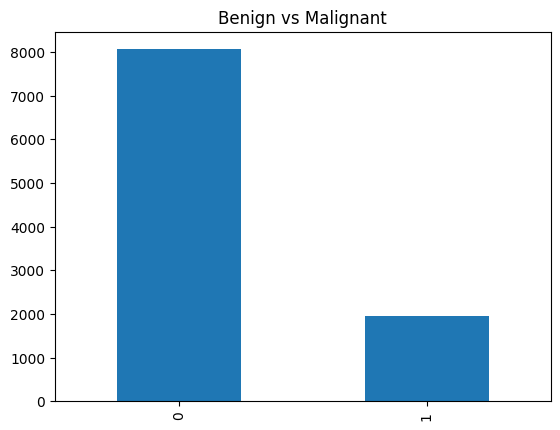

In [ ]:
tile_df["malignant"].value_counts().plot(kind="bar", title="Benign vs Malignant")

<Axes: title={'center': 'Counts for each type of Lesions'}>

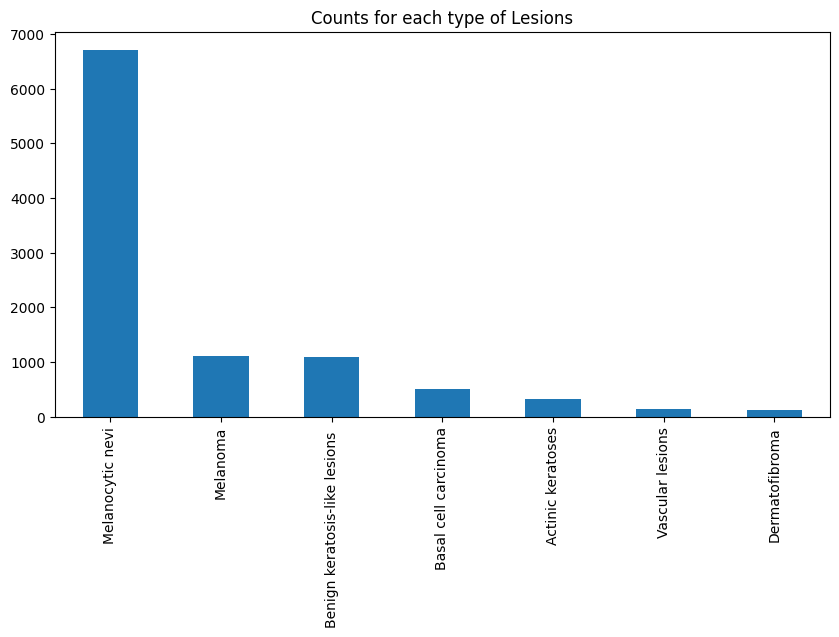

In [ ]:
fig, ax1 = plt.subplots(1,1,figsize=(10,5))
tile_df["cell_type"].value_counts().plot(kind="bar", ax=ax1, title="Counts for each type of Lesions")

O conjunto de dados é tendencioso para nevos melanocíticos. O tipo de célula com o segundo maior número de amostras é o melanoma.

<Axes: title={'center': 'Location of Lesions'}>

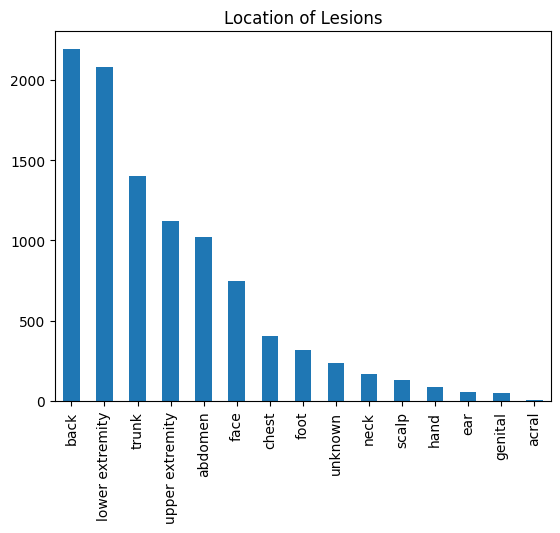

In [ ]:
# let's see where lesions are mostly located
tile_df["localization"].value_counts().plot(kind='bar', title="Location of Lesions")

<Axes: title={'center': 'Treatment received'}>

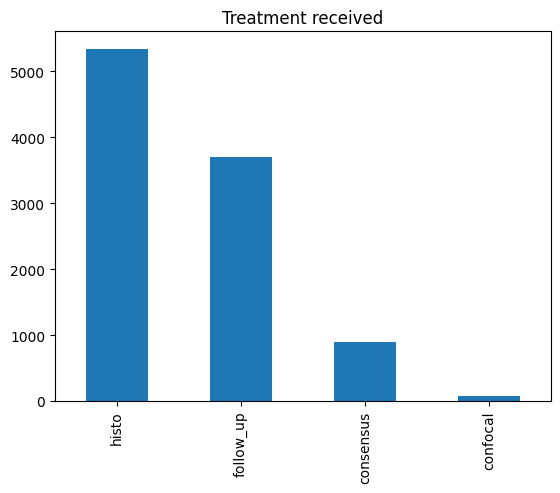

In [ ]:
tile_df["dx_type"].value_counts().plot(kind='bar', title="Treatment received")

histo: "Os diagnósticos histopatológicos de lesões excisadas foram realizados por dermatopatologistas especializados."

follow_up: "Se os nevos monitorados por dermatoscopia digital não mostraram quaisquer alterações durante 3 consultas de acompanhamento ou 1,5 anos, aceitamos isso como evidência de benignidade biológica. Apenas os nevos, mas nenhum outro diagnóstico benigno, foi rotulado com este tipo de verdade porque os dermatologistas geralmente não monitoram dermatofibromas, ceratoses seborreicas ou lesões vasculares."

consenso: "Para casos benignos típicos sem histopatologia ou acompanhamento, fornecemos uma classificação de consenso de especialistas dos autores PT e HK. Aplicamos o rótulo de consenso apenas se ambos os autores deram independentemente o mesmo diagnóstico benigno inequívoco. Lesões com este tipo de verdade foram geralmente fotografado por motivos educacionais e não precisou de acompanhamento adicional ou biópsia para confirmação."

confocal: "A microscopia confocal de refletância é uma técnica de imagem in vivo com resolução em nível quase celular, e algumas ceratoses faciais benignas foram verificadas por este método."

<Axes: >

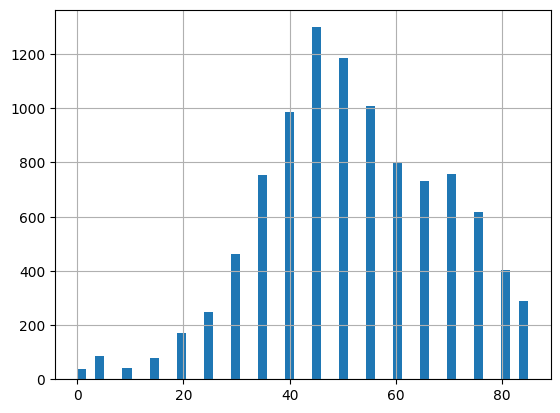

In [ ]:
tile_df["age"].hist(bins=50)

<Axes: >

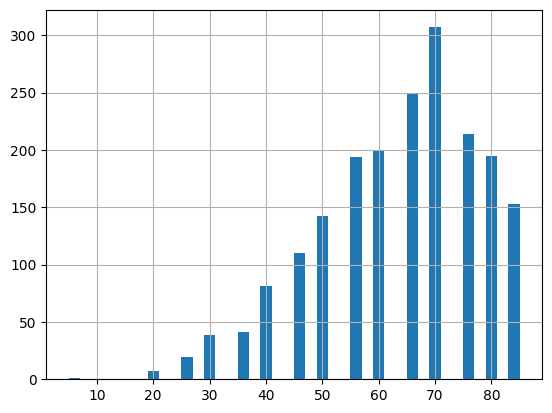

In [ ]:
tile_df[tile_df["malignant"] == 1]["age"].hist(bins=40)

<Axes: title={'center': 'Male vs Female'}>

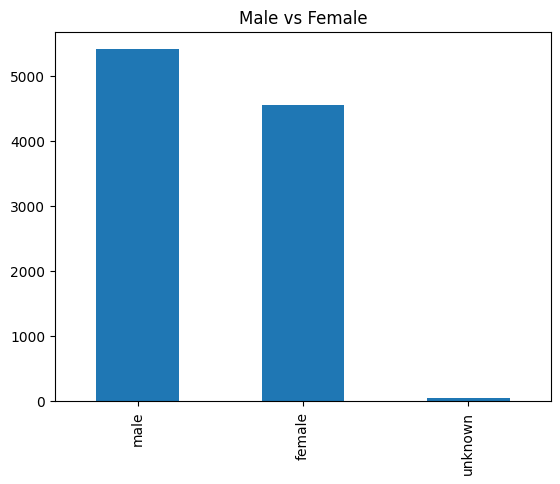

In [ ]:
tile_df["sex"].value_counts().plot(kind="bar", title="Male vs Female")

<Axes: title={'center': 'Male vs Female. Malignant'}>

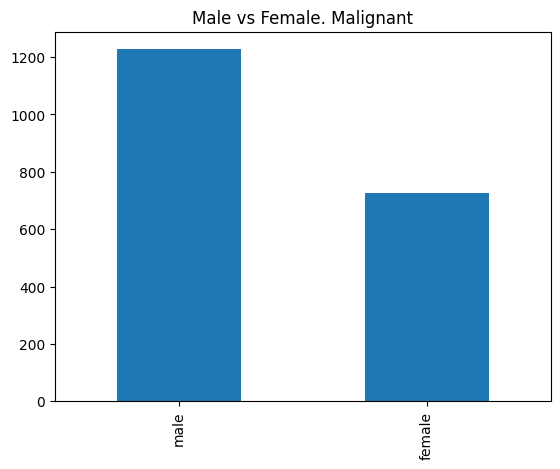

In [ ]:
tile_df[tile_df["malignant"] == 1]["sex"].value_counts().plot(kind="bar", title="Male vs Female. Malignant")

---
# Pré-processamento dos dados

In [ ]:
input_dims = (224, 224)
input_shape = input_dims + (3,)

# Load in all of the images into memory - this will take a while.
# We also do a resize step because the original dimensions of 450 * 600 * 3 was too much for TensorFlow

tile_df['image'] = tile_df['path'].map(lambda x: np.asarray(Image.open(x).resize(input_dims)))

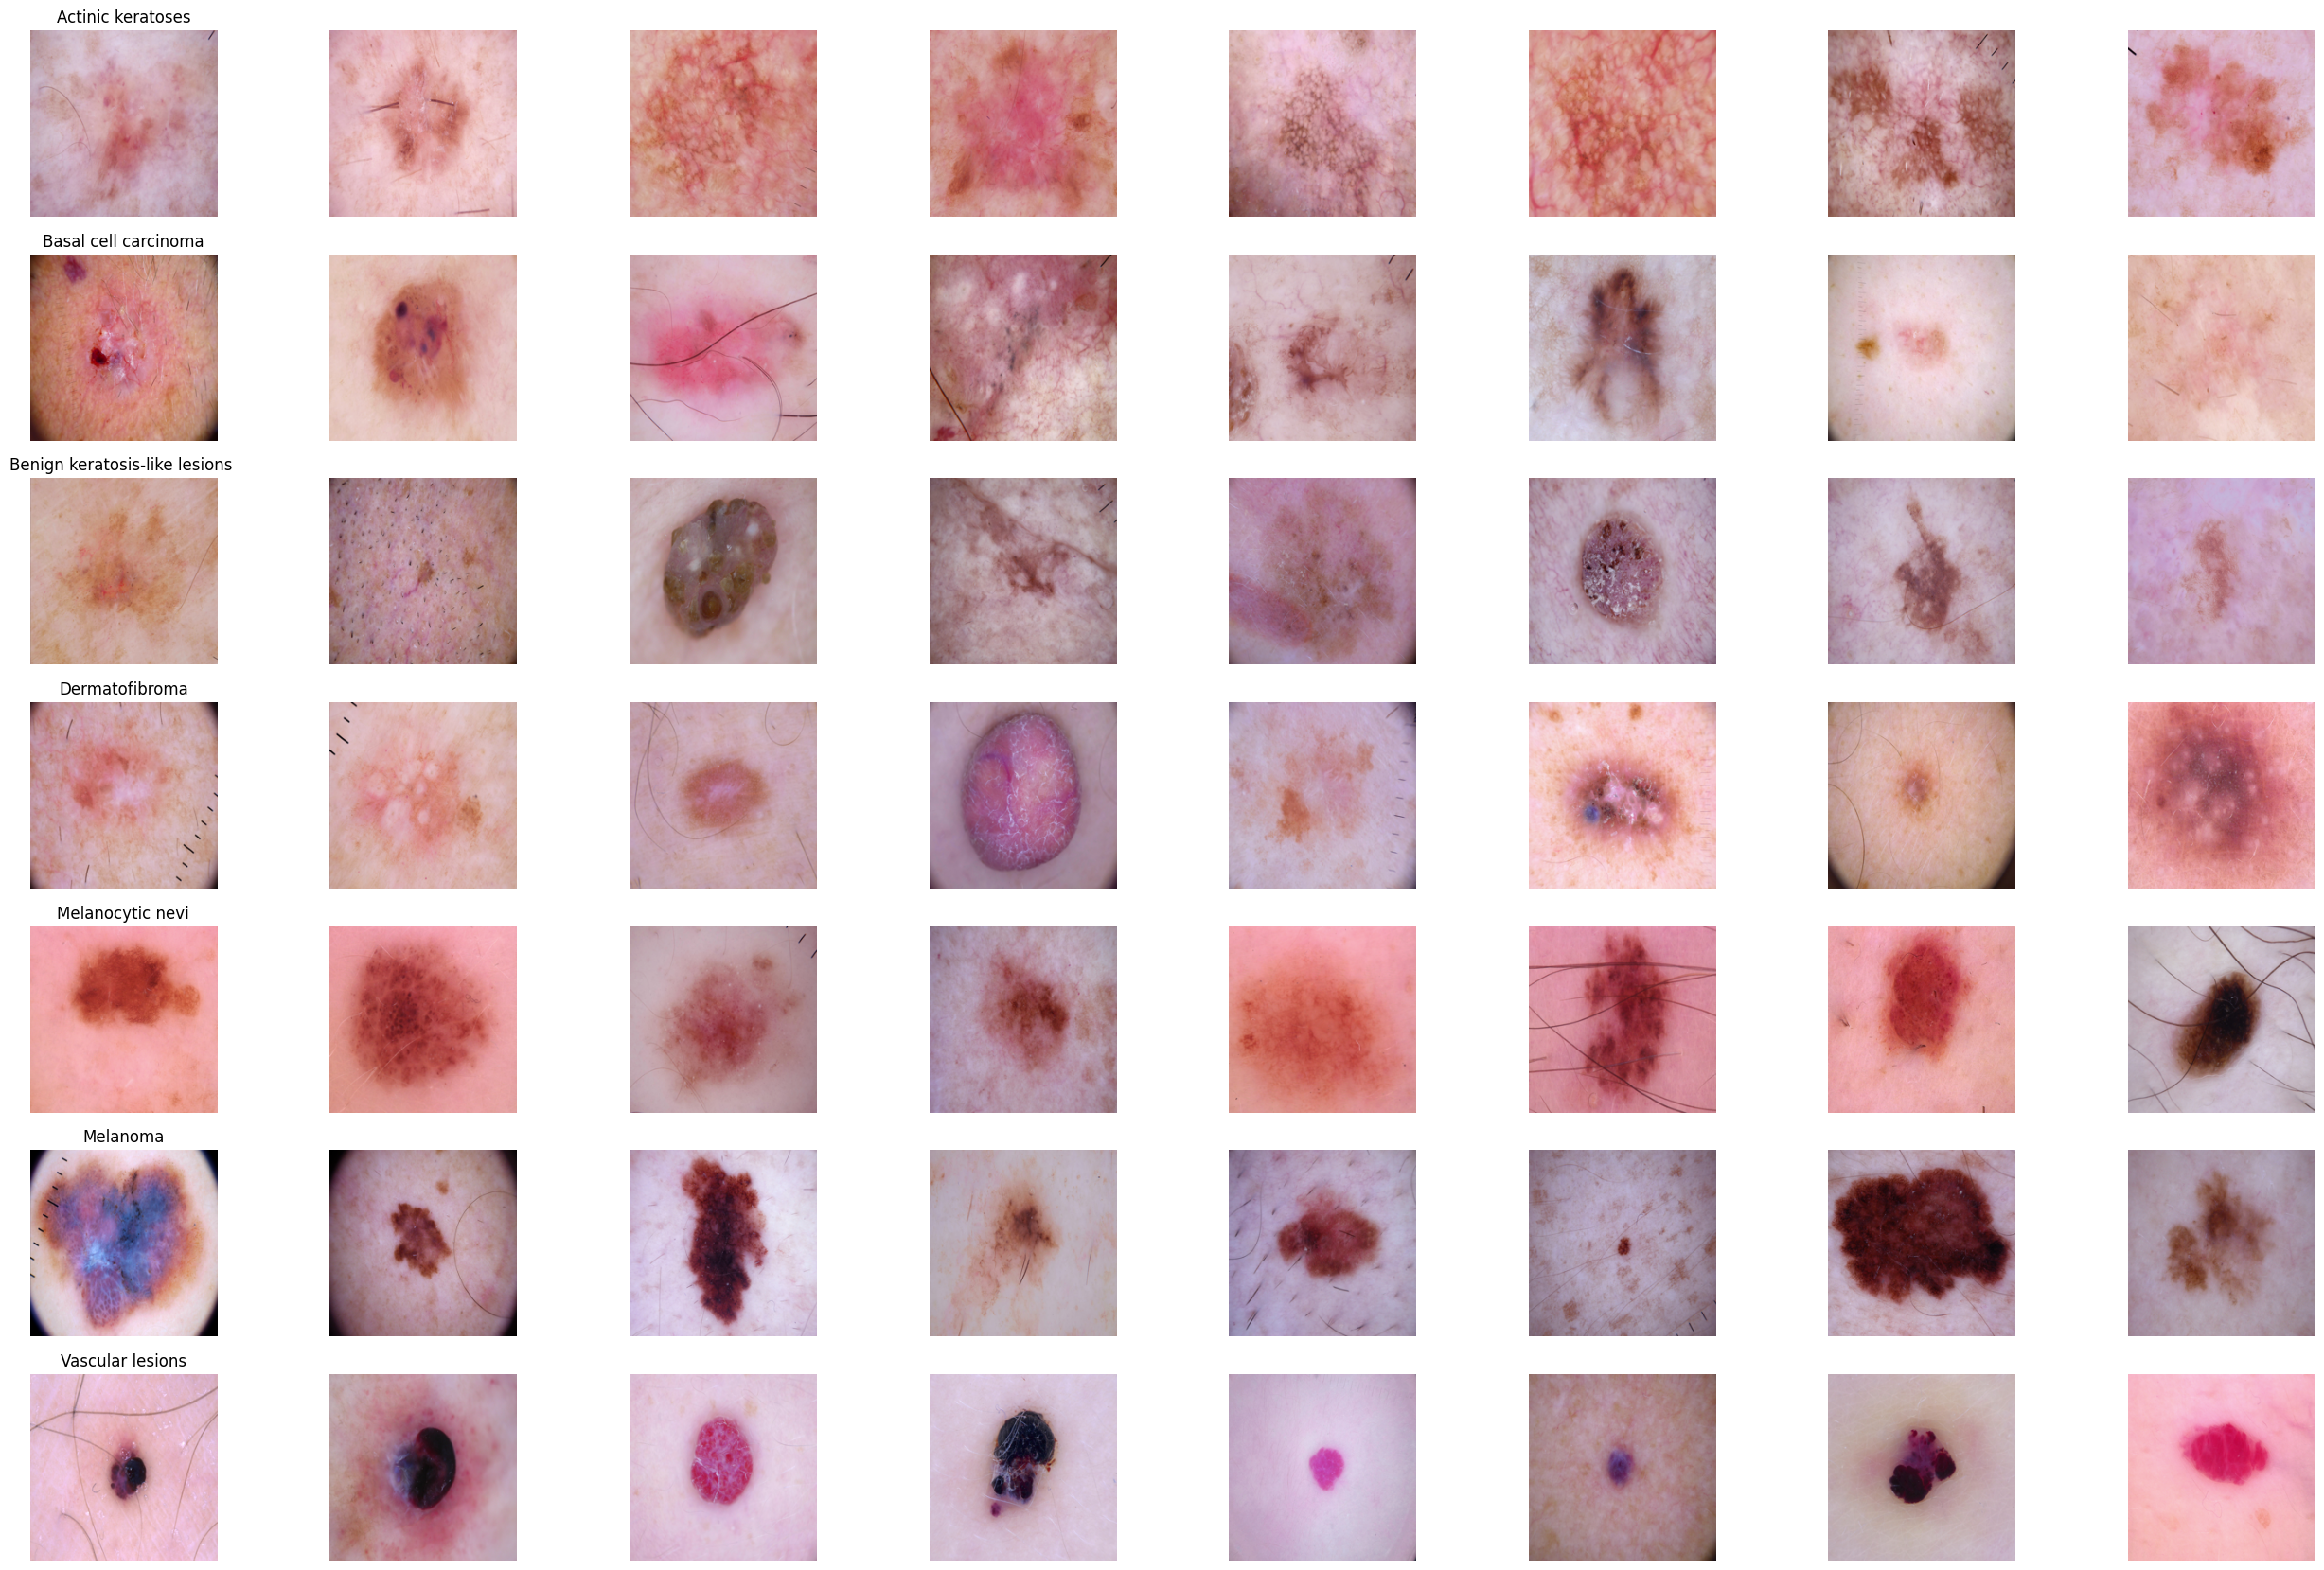

In [ ]:
n_samples = 8
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs,
                                         tile_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
# fig.savefig('category_samples.png', dpi=300)

In [ ]:
# See the image size distribution - should just return one row (all images are uniform)
tile_df['image'].map(lambda x: x.shape).value_counts()

(224, 224, 3)    10015
Name: image, dtype: int64

Melanocytic nevi                  6705
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: cell_type, dtype: int64


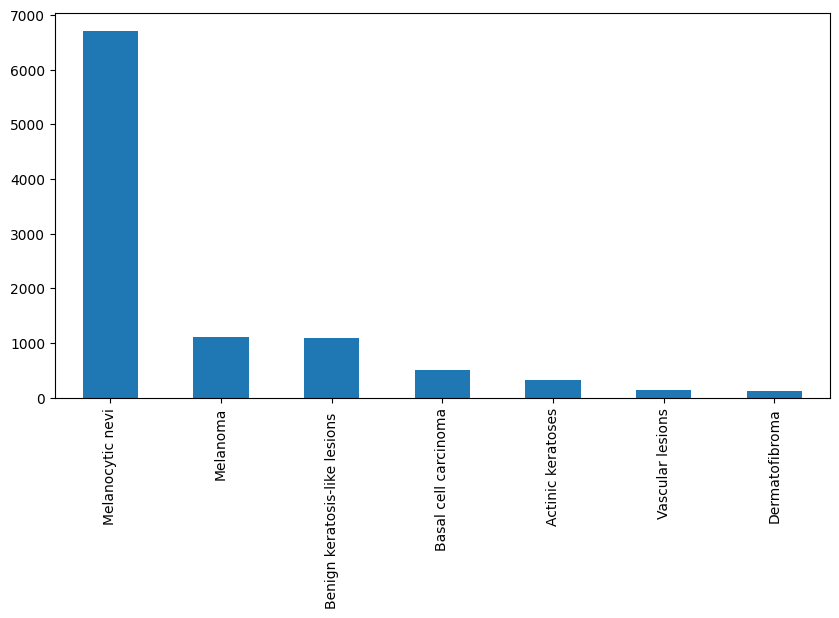

In [ ]:
# Ver o desbalanceamento das classes antes de excluir 5005 linhas da classe 4
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
tile_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

print(tile_df['cell_type'].value_counts())

Benign keratosis-like lesions     500
Melanoma                          500
Basal cell carcinoma              500
Melanocytic nevi                  500
Actinic keratoses                 327
Vascular lesions                  142
Dermatofibroma                    115
Name: cell_type, dtype: int64


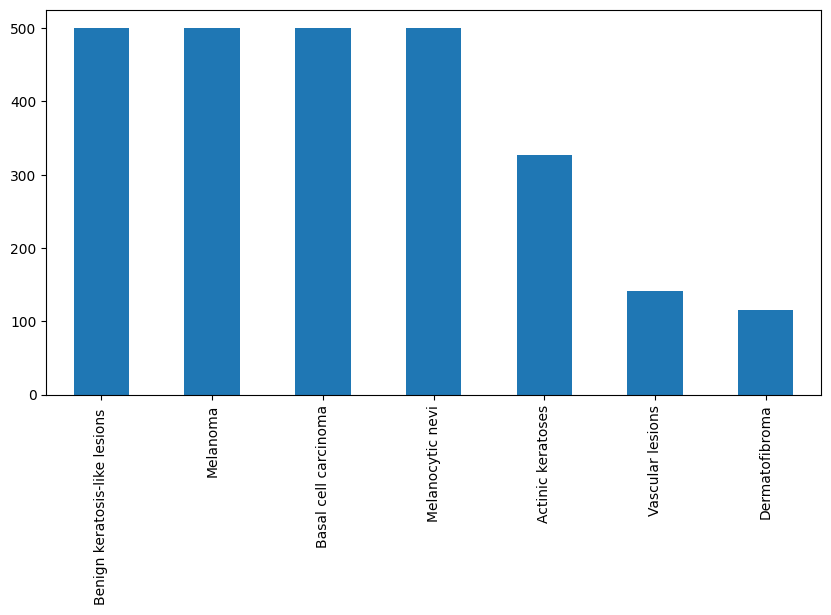

In [ ]:
# Too many melanocytic nevi - let's balance it a bit!
# Excluindo as 6005 linhas da classe 4 de forma aleatória
# tile_df = tile_df.drop(tile_df[tile_df.cell_type_idx == 4].iloc[:5005].index)
melanocytic_drop = tile_df[tile_df.cell_type_idx == 4].sample(n=6205).index
melanoma_drop = tile_df[tile_df.cell_type_idx == 5].sample(n=613).index
benign_drop = tile_df[tile_df.cell_type_idx == 2].sample(n=599).index
basal_drop = tile_df[tile_df.cell_type_idx == 1].sample(n=14).index

tile_df = tile_df.drop(melanocytic_drop)
tile_df = tile_df.drop(melanoma_drop)
tile_df = tile_df.drop(benign_drop)
tile_df = tile_df.drop(basal_drop)

fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
tile_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

print(tile_df['cell_type'].value_counts())

In [ ]:
# Export to csv
tile_df.to_csv('processed_data.csv', index= False)


In [ ]:
# download do processed_data
processed_data_df = pd.read_csv('/content/processed_data.csv')
print(processed_data_df.shape)
processed_data_df.head()

(2584, 12)


lesion_id      image_id   dx dx_type   age     sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0    male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0    male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0    male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0    male        scalp   
4  HAM_0005132  ISIC_0025837  bkl   histo  70.0  female         back   

                                                path  \
0  /content/skin-cancer-mnist-ham10000/ham10000_i...   
1  /content/skin-cancer-mnist-ham10000/ham10000_i...   
2  /content/skin-cancer-mnist-ham10000/ham10000_i...   
3  /content/skin-cancer-mnist-ham10000/ham10000_i...   
4  /content/skin-cancer-mnist-ham10000/ham10000_i...   

                        cell_type  malignant  cell_type_idx  \
0  Benign keratosis-like lesions           0              2   
1  Benign keratosis-like lesions           0              2   
2  Benign keratosis-like lesions           0              2   
3  Benign keratosis-like lesions           0              2   
4  Benign keratosis-like lesions           0              2   

                                               image  
0  [[[187 150 192]\n  [190 154 195]\n  [192 156 1...  
1  [[[24 13 22]\n  [25 13 23]\n  [24 14 23]\n  .....  
2  [[[186 127 135]\n  [188 129 137]\n  [191 135 1...  
3  [[[23 11 15]\n  [24 11 18]\n  [24 10 19]\n  .....  
4  [[[ 93  60  59]\n  [ 99  65  64]\n  [105  72  ...

In [ ]:
# Função para balanceamento das classes com menos de 500 imagens,
# gerar um novo dataframe e salvar as imagens que foram modificadas na pasta augmentation_dir
def pregenerate_augmented_images(df, augmentation_dir, target_size=(224, 224), num_images_per_class=500):
    '''
    df: DataFrame original contendo as informações das imagens.
    augmentation_dir: Caminho do diretório onde as imagens aumentadas serão salvas.
    target_size: Tamanho alvo das imagens (deve ser o mesmo que será usado para o treinamento).
    num_images_per_class: Número desejado de imagens por classe.
    '''
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Certifique-se de que o diretório de augmentation existe
    if not os.path.exists(augmentation_dir):
        os.makedirs(augmentation_dir)

    class_counts = df['cell_type'].value_counts()
    augmented_images_info = []  # Para armazenar informações das novas imagens

    for class_name, count in class_counts.items():
        if count < num_images_per_class:
            # Calcula quantas imagens são necessárias para cada classe
            deficit = num_images_per_class - count
            class_df = df[df['cell_type'] == class_name]
            generated_count = 0

            while generated_count < deficit:
                for index, row in class_df.iterrows():
                    img_path = row['path']
                    img = load_img(img_path, target_size=target_size)
                    x = img_to_array(img)
                    x = x.reshape((1,) + x.shape)

                    # O loop abaixo gera uma imagem por vez
                    for x_aug in datagen.flow(x, batch_size=1):
                        # Salva a imagem augmentada no diretório especificado
                        aug_img_path = os.path.join(augmentation_dir, f"{row['image_id'].split('.')[0]}_aug_{generated_count}.jpg")
                        img_to_save = x_aug[0].astype(np.uint8)
                        save_img(aug_img_path, img_to_save)

                        # Copia as informações do DataFrame original e atualiza o caminho e image_id
                        new_row = row.copy()
                        new_row['path'] = aug_img_path
                        new_row['image_id'] = f"{row['image_id'].split('.')[0]}_aug_{generated_count}.jpg"

                        # Atualiza as informações das novas imagens
                        # augmented_images_info.append([aug_img_path, class_name])
                        augmented_images_info.append(new_row)

                        generated_count += 1
                        if generated_count >= deficit:
                            break
                    if generated_count >= deficit:
                        break

    # Adiciona as novas imagens ao DataFrame original
    # new_images_df = pd.DataFrame(augmented_images_info, columns=['image_id', 'dx'])
    new_images_df = pd.DataFrame(augmented_images_info)
    updated_df = pd.concat([df, new_images_df], ignore_index=True)

    # Opcional: embaralhar o DataFrame resultante para garantir uma distribuição aleatória
    updated_df = shuffle(updated_df).reset_index(drop=True)

    return updated_df


In [ ]:
updated_df = pregenerate_augmented_images(processed_data_df, '/content/augmentation_dir/')

In [ ]:
updated_df.head()

lesion_id      image_id     dx    dx_type   age     sex     localization  \
0  HAM_0002591  ISIC_0031389    mel      histo  55.0  female  lower extremity   
1  HAM_0004621  ISIC_0025818    bcc      histo  70.0  female             back   
2  HAM_0003094  ISIC_0029647    bcc      histo  75.0    male  upper extremity   
3  HAM_0003905  ISIC_0029275     nv  follow_up  35.0    male  upper extremity   
4  HAM_0004809  ISIC_0031108  akiec      histo  60.0    male             face   

                                                path             cell_type  \
0  /content/skin-cancer-mnist-ham10000/HAM10000_i...              Melanoma   
1  /content/skin-cancer-mnist-ham10000/ham10000_i...  Basal cell carcinoma   
2  /content/skin-cancer-mnist-ham10000/HAM10000_i...  Basal cell carcinoma   
3  /content/skin-cancer-mnist-ham10000/ham10000_i...      Melanocytic nevi   
4  /content/skin-cancer-mnist-ham10000/HAM10000_i...     Actinic keratoses   

   malignant  cell_type_idx                                              image  
0          1              5  [[[200 175 171]\n  [201 177 173]\n  [204 176 1...  
1          1              1  [[[201 184 176]\n  [202 186 182]\n  [205 189 1...  
2          1              1  [[[35 19 20]\n  [34 19 23]\n  [37 24 32]\n  .....  
3          0              4  [[[232 145 153]\n  [230 144 153]\n  [230 143 1...  
4          1              0  [[[175 116  96]\n  [189 127 103]\n  [188 128 1...

In [ ]:
updated_df.shape

(3500, 12)

<Axes: >

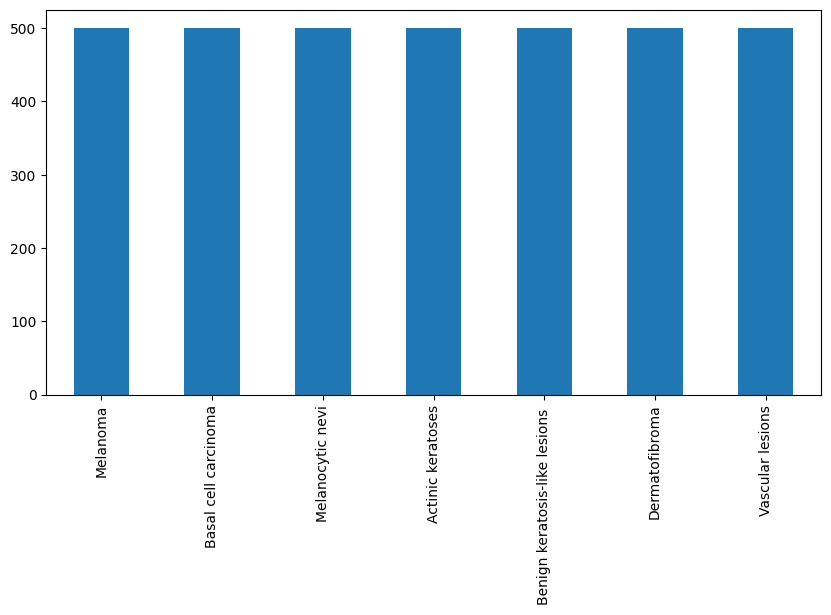

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
updated_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

In [ ]:
unique_rows_view = updated_df.groupby('cell_type_idx').first().reset_index()

unique_rows_view

cell_type_idx    lesion_id                  image_id     dx    dx_type  \
0              0  HAM_0004809              ISIC_0031108  akiec      histo   
1              1  HAM_0004621              ISIC_0025818    bcc      histo   
2              2  HAM_0001536              ISIC_0026842    bkl      histo   
3              3  HAM_0006371              ISIC_0033626     df  consensus   
4              4  HAM_0003905              ISIC_0029275     nv  follow_up   
5              5  HAM_0002591              ISIC_0031389    mel      histo   
6              6  HAM_0006889  ISIC_0031197_aug_289.jpg   vasc      histo   

    age     sex     localization  \
0  60.0    male             face   
1  70.0  female             back   
2  45.0  female             face   
3  35.0  female  lower extremity   
4  35.0    male  upper extremity   
5  55.0  female  lower extremity   
6  20.0    male  upper extremity   

                                                path  \
0  /content/skin-cancer-mnist-ham10000/HAM10000_i...   
1  /content/skin-cancer-mnist-ham10000/ham10000_i...   
2  /content/skin-cancer-mnist-ham10000/ham10000_i...   
3  /content/skin-cancer-mnist-ham10000/HAM10000_i...   
4  /content/skin-cancer-mnist-ham10000/ham10000_i...   
5  /content/skin-cancer-mnist-ham10000/HAM10000_i...   
6  /content/augmentation_dir/ISIC_0031197_aug_289...   

                        cell_type  malignant  \
0               Actinic keratoses          1   
1            Basal cell carcinoma          1   
2  Benign keratosis-like lesions           0   
3                  Dermatofibroma          0   
4                Melanocytic nevi          0   
5                        Melanoma          1   
6                Vascular lesions          0   

                                               image  
0  [[[175 116  96]\n  [189 127 103]\n  [188 128 1...  
1  [[[201 184 176]\n  [202 186 182]\n  [205 189 1...  
2  [[[151 101 121]\n  [163 107 128]\n  [157 102 1...  
3  [[[133 117 126]\n  [138 117 130]\n  [139 118 1...  
4  [[[232 145 153]\n  [230 144 153]\n  [230 143 1...  
5  [[[200 175 171]\n  [201 177 173]\n  [204 176 1...  
6  [[[218 188 210]\n  [219 186 209]\n  [221 186 2...

In [ ]:
updated_df.to_csv('df_aug.csv', index= False)

---
# Separação dos dados em TVT

In [ ]:
def images_to_array(dataframe, target_size=(224, 224)):
    image_list = []
    for index, row in dataframe.iterrows():
        img_path = row['path']
        img = load_img(img_path, target_size=target_size)
        img_array = img_to_array(img)
        img_array = img_array / 255.0  # Normalizando para o intervalo [0, 1]
        image_list.append(img_array)
    return np.array(image_list)

In [ ]:
# Separando a coluna label
y = updated_df.cell_type_idx

# Primeira divisão: dividindo em treino e teste
x_train_val, x_test_o, y_train_val, y_test_o = train_test_split(updated_df, y, test_size=0.25, random_state=42)

# Segunda divisão: dividindo o conjunto de treino em treino e validação (ex: 80% treino, 20% validação)
x_train_o, x_val_o, y_train_o, y_val_o = train_test_split(x_train_val, y_train_val, test_size=0.20, random_state=42) # Ajuste o test_size conforme necessário

# Convertendo as imagens para numpy arrays e normalizando
x_train = images_to_array(x_train_o)
x_val = images_to_array(x_val_o)
x_test = images_to_array(x_test_o)

# Convertendo rótulos para categóricos
y_train = to_categorical(y_train_o, num_classes=7)
y_val = to_categorical(y_val_o, num_classes=7)
y_test = to_categorical(y_test_o, num_classes=7)


In [ ]:
print(x_train.shape, x_val.shape, x_test.shape)

(2100, 224, 224, 3) (525, 224, 224, 3) (875, 224, 224, 3)


In [ ]:
print(y_train.shape, y_val.shape, y_test.shape)

(2100, 7) (525, 7) (875, 7)


In [ ]:
total_images = len(updated_df)  # Total de imagens no DataFrame atualizado
expected_train_val_size = total_images * 0.75  # 75% para treino + validação
expected_test_size = total_images * 0.25  # 25% para teste

expected_train_size = expected_train_val_size * 0.8  # 80% de treino_val para treino
expected_val_size = expected_train_val_size * 0.2  # 20% de treino_val para validação

print(f"Esperado (Treino): {expected_train_size}, Real (Treino): {x_train.shape[0]}")
print(f"Esperado (Validação): {expected_val_size}, Real (Validação): {x_val.shape[0]}")
print(f"Esperado (Teste): {expected_test_size}, Real (Teste): {x_test.shape[0]}")

Esperado (Treino): 2100.0, Real (Treino): 2100
Esperado (Validação): 525.0, Real (Validação): 525
Esperado (Teste): 875.0, Real (Teste): 875


---
# Optuna

In [ ]:
input_shape = (224, 224, 3)
num_classes = 7

In [ ]:
def custom_cnn(num_conv_layers, filters, kernel_sizes, dropout_rate, learning_rate, input_shape, num_classes):
    model = Sequential()

    # Adiciona camadas convolucionais
    for i in range(num_conv_layers):
        if i == 0:
            model.add(Conv2D(filters[i], kernel_sizes[i], activation='relu', input_shape=input_shape))
        else:
            model.add(Conv2D(filters[i], kernel_sizes[i], activation='relu'))
        model.add(MaxPooling2D((2, 2)))

    # Flatten e camadas densas
    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(units=num_classes, activation='softmax'))  # Para o número dinâmico de classes

    # Compile o modelo
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [ ]:
def create_model(trial, input_shape, num_classes):
    # Seleciona o modelo base pré-treinado

    base_model_selector = trial.suggest_categorical('base_model', ['EfficientNetB0', 'ResNet50', 'VGG16', 'InceptionV3', 'custom_cnn'])

    if base_model_selector == 'custom_cnn':
        # Gera hiperparâmetros para o modelo customizado
        num_conv_layers = trial.suggest_int("num_conv_layers", 1, 3)
        filters = [trial.suggest_int(f"filters_{i}", 16, 128) for i in range(num_conv_layers)]
        kernel_sizes = [(trial.suggest_int(f"kernel_size_{i}", 3, 5), trial.suggest_int(f"kernel_size_{i}", 3, 5)) for i in range(num_conv_layers)]
        dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.5)
        learning_rate = trial.suggest_float('lr', 1e-5, 1e-2, log=True)

        # Cria o modelo customizado
        model = custom_cnn(num_conv_layers, filters, kernel_sizes, dropout_rate, learning_rate, input_shape, num_classes)
    else:
        if base_model_selector == 'EfficientNetB0':
            base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)
        elif base_model_selector == 'ResNet50':
            base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
        elif base_model_selector == 'VGG16':
            base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
        elif base_model_selector == 'InceptionV3':
            base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)


        base_model.trainable = False  # Congela as camadas do modelo base
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(trial.suggest_int('dense_units', 256, 1024), activation='relu')(x)
        x = Dropout(trial.suggest_float('dropout_rate', 0.2, 0.5))(x)
        predictions = Dense(num_classes, activation='softmax')(x)
        model = Model(inputs=base_model.input, outputs=predictions)
        learning_rate = trial.suggest_float('lr', 1e-5, 1e-2, log=True)

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
def objective(trial):
    model = create_model(trial, input_shape, num_classes)

    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    epochs = 10  # Ou outro valor fixo

    # Treina o modelo
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, batch_size=batch_size, verbose=0)

    # Retorna a acurácia de validação
    val_accuracy = history.history['val_accuracy'][-1]
    return val_accuracy


In [ ]:
def save_study_callback(study, trial, filename='my_study.pkl'):
    """Função de callback para salvar o estudo."""
    with open(filename, 'wb') as f:
        pickle.dump(study, f)

In [ ]:
study = optuna.create_study(direction='maximize', study_name='Dermatology-Image-Classification', sampler=optuna.samplers.TPESampler(seed=123))
study.optimize(objective, n_trials=5, callbacks=[lambda study, trial: save_study_callback(study, trial, 'my_study.pkl')])  # Ajuste 'n_trials' conforme necessário


[I 2024-02-23 10:33:26,323] A new study created in memory with name: Dermatology-Image-Classification
[I 2024-02-23 10:35:54,807] Trial 0 finished with value: 0.3447619080543518 and parameters: {'base_model': 'custom_cnn', 'num_conv_layers': 2, 'filters_0': 126, 'filters_1': 93, 'kernel_size_0': 4, 'kernel_size_1': 4, 'dropout_rate': 0.30295340484526084, 'lr': 0.001538682881677986, 'batch_size': 16}. Best is trial 0 with value: 0.3447619080543518.


16705208/16705208 [==============================] - 0s 0us/step


[I 2024-02-23 10:37:31,073] Trial 1 finished with value: 0.11809524148702621 and parameters: {'base_model': 'EfficientNetB0', 'dense_units': 743, 'dropout_rate': 0.4548295382233369, 'lr': 0.0014906166728108333, 'batch_size': 32}. Best is trial 0 with value: 0.3447619080543518.


87910968/87910968 [==============================] - 1s 0us/step


[I 2024-02-23 10:39:08,967] Trial 2 finished with value: 0.645714282989502 and parameters: {'base_model': 'InceptionV3', 'dense_units': 589, 'dropout_rate': 0.32925882899889314, 'lr': 0.0003027298829337906, 'batch_size': 64}. Best is trial 2 with value: 0.645714282989502.


94765736/94765736 [==============================] - 1s 0us/step


[I 2024-02-23 10:41:41,123] Trial 3 finished with value: 0.11809524148702621 and parameters: {'base_model': 'ResNet50', 'dense_units': 499, 'dropout_rate': 0.32444786358608957, 'lr': 0.003971252247766701, 'batch_size': 64}. Best is trial 2 with value: 0.645714282989502.
[I 2024-02-23 10:43:14,815] Trial 4 finished with value: 0.653333306312561 and parameters: {'base_model': 'InceptionV3', 'dense_units': 675, 'dropout_rate': 0.3028291501322925, 'lr': 8.172639965350114e-05, 'batch_size': 64}. Best is trial 4 with value: 0.653333306312561.


In [ ]:
print('Número de trials finalizados:', len(study.trials))
print('Melhor trial:', study.best_trial.params)

Número de trials finalizados: 5
Melhor trial: {'base_model': 'InceptionV3', 'dense_units': 675, 'dropout_rate': 0.3028291501322925, 'lr': 8.172639965350114e-05, 'batch_size': 64}


In [ ]:
best_trial = study.best_trial

In [ ]:
best_model = create_model(best_trial, input_shape=(224, 224, 3), num_classes=num_classes)
best_model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=64)


Epoch 1/20
66/66 [==============================] - 18s 155ms/step - loss: 1.4196 - accuracy: 0.4714 - val_loss: 1.1998 - val_accuracy: 0.5600
Epoch 2/20
66/66 [==============================] - 6s 93ms/step - loss: 1.0386 - accuracy: 0.6171 - val_loss: 1.1012 - val_accuracy: 0.5771
Epoch 3/20
66/66 [==============================] - 6s 89ms/step - loss: 0.9297 - accuracy: 0.6548 - val_loss: 1.0799 - val_accuracy: 0.5638
Epoch 4/20
66/66 [==============================] - 6s 95ms/step - loss: 0.8527 - accuracy: 0.6733 - val_loss: 1.0235 - val_accuracy: 0.6210
Epoch 5/20
66/66 [==============================] - 6s 90ms/step - loss: 0.7898 - accuracy: 0.7176 - val_loss: 1.0151 - val_accuracy: 0.6171
Epoch 6/20
66/66 [==============================] - 6s 95ms/step - loss: 0.7362 - accuracy: 0.7338 - val_loss: 0.9944 - val_accuracy: 0.6210
Epoch 7/20
66/66 [==============================] - 6s 92ms/step - loss: 0.6754 - accuracy: 0.7648 - val_loss: 0.9721 - val_accuracy: 0.6305
Epoch 8/20


In [ ]:
best_model.save('content/best_model.h5')

---

# MLFlow

In [ ]:
mlflow.start_run(run_name='Dermatology-Image-Classification')

<ActiveRun: >

In [ ]:
model_path = 'content/best_model.h5'
model = load_model(model_path)

In [ ]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

Test Accuracy: 66.29%


In [ ]:
mlflow.log_metric("test_loss", test_loss)
mlflow.log_metric("test_accuracy", test_accuracy)

In [ ]:
# Supondo que seu modelo produza probabilidades como saída e que y_test seja categórico
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Calculando precisão, recall, e F1-score
report = classification_report(true_classes, predicted_classes, output_dict=True)

# Calculando a matriz de confusão
conf_matrix = confusion_matrix(true_classes, predicted_classes)

28/28 [==============================] - 3s 68ms/step


In [ ]:
# Supondo que 'report' seja o dicionário retornado por classification_report(output_dict=True)
weighted_avg_precision = report['weighted avg']['precision']
weighted_avg_recall = report['weighted avg']['recall']
weighted_avg_f1_score = report['weighted avg']['f1-score']

# Logando os valores médios ponderados no MLflow
mlflow.log_metric("weighted_avg_precision", weighted_avg_precision)
mlflow.log_metric("weighted_avg_recall", weighted_avg_recall)
mlflow.log_metric("weighted_avg_f1_score", weighted_avg_f1_score)

print(f"Weighted Average Precision: {weighted_avg_precision:.2f}")
print(f"Weighted Average Recall: {weighted_avg_recall:.2f}")
print(f"Weighted Average F1-Score: {weighted_avg_f1_score:.2f}")


Weighted Average Precision: 0.68
Weighted Average Recall: 0.66
Weighted Average F1-Score: 0.67


In [ ]:
# for label, metrics in report.items():
#     if label.isdigit():  # Verifica se é uma classe (labels são digitos como strings)
#         mlflow.log_metric(f"class_{label}_precision", metrics['precision'])
#         mlflow.log_metric(f"class_{label}_recall", metrics['recall'])
#         mlflow.log_metric(f"class_{label}_f1-score", metrics['f1-score'])


In [ ]:
conf_matrix_df = pd.DataFrame(conf_matrix)
temp_file = "confusion_matrix.csv"
conf_matrix_df.to_csv(temp_file)
mlflow.log_artifact(temp_file, "confusion_matrix_files")

In [ ]:
class_names = ['Actinic keratoses', 'Basal cell carcinoma', 'Benign keratosis-like lesions', 'Dermatofibroma', 'Melanocytic nevi', 'Melanoma', 'Vascular lesions']

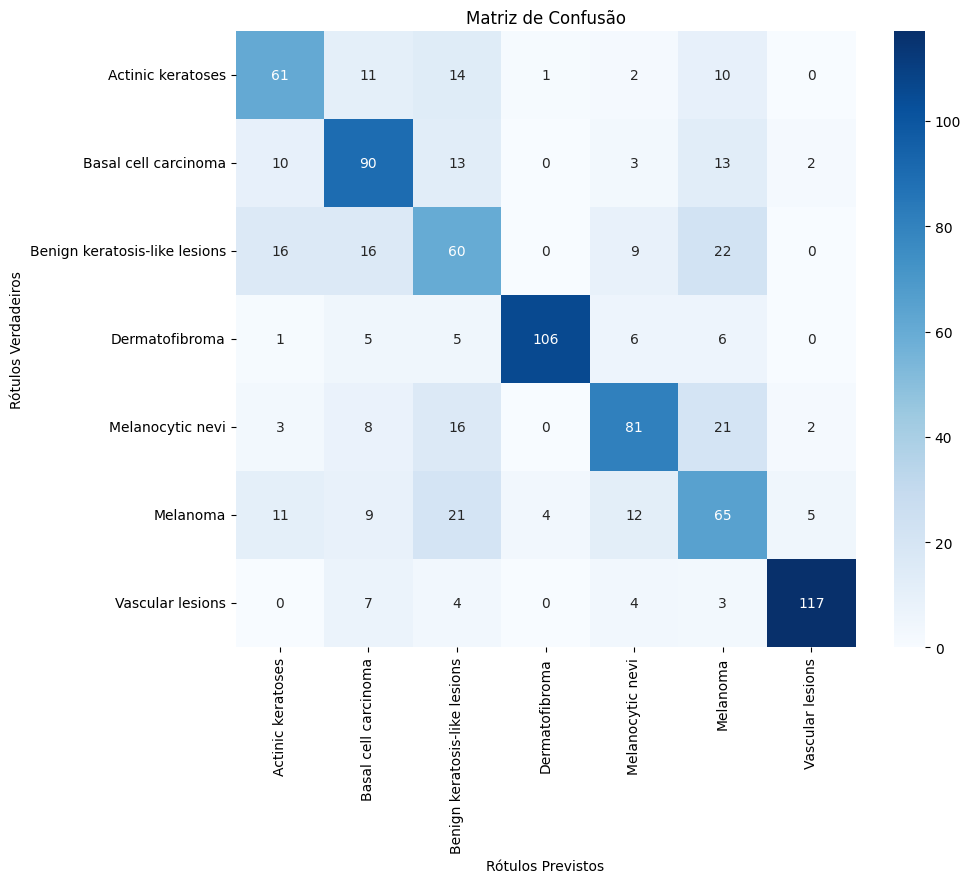

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=True, xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Rótulos Previstos')
plt.ylabel('Rótulos Verdadeiros')
plt.title('Matriz de Confusão')
plt.show()

In [ ]:
os.remove(temp_file)  # Limpeza do arquivo temporário

In [ ]:
mlflow.end_run()

- Acurácia de teste: 66%
- Precisão: 68%
- Recall: 66%
- F1-Score: 67%

Motivo: custo computacional (poucas imagens, poucas épocas, pouco trials, redes neurais com poucas camadas (mais simples)).
  - GPU do Colab acabando
  - RAM do Colab passando do limite de 12GB.

- Melhorias:
  - Aumentar a quantidade de imagens para 1000 por classe
  - Aumentar a quantidade de épocas (+20)
  - Aumentar a quantidade de trials (+50)
  - Testar outros modelos de redes neurais

---